# Code Optimization
## How to best optimize code in Julia
Using Mandelbrot sets I'm going to explore how to optimize our code.

In [1]:
using BenchmarkTools
using Plots, PlotUtils

In [2]:
@doc raw"""
c0::Complex is the complex number
maxitter::Integer Number of 
Compues the mandelbrot function
"""
function mandelbrot(c0::Complex, maxitter::Integer)
    c = 0
    for i = 1:maxitter
        if abs(c) > 2
            return i
        end
        c = c^2 + c0
    end
    return maxitter
end

function mandelbrot_set(rmin, rmax, imin, imax, width, height, maxitter = 200)
    real_num = range(rmin, rmax, length = width)
    im_num = range(imin, imax, length = width)
    img = zeros(Integer, height, width)
    for r ∈ 1:width
        for i ∈ 1:height
            c = complex(real_num[r], im_num[i])
            img[i, r] = mandelbrot(c, maxitter)
        end
    end
    img
end

mandelbrot_set (generic function with 2 methods)

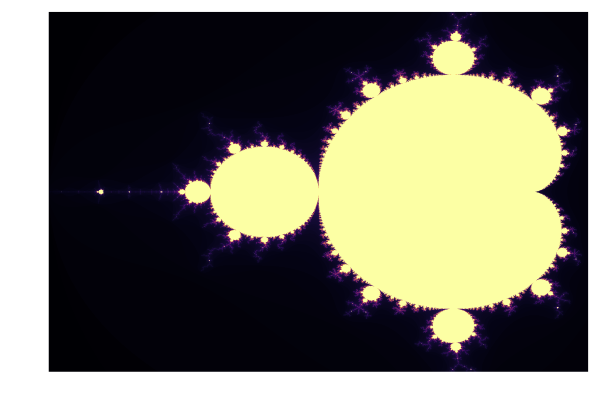

In [3]:
image_man = mandelbrot_set(-2.0, 0.5, -1, 1, 2000, 2000)
bn_original = @benchmark image_man = mandelbrot_set(-2.0, 0.5, -1, 1, 2000, 2000)
heatmap(image_man,
        colorbar = :none,
        axis=false,
        grid=false,
        framestyle=:none,
        color=:inferno)


In [4]:
bn_original

BenchmarkTools.Trial: 
  memory estimate:  30.52 MiB
  allocs estimate:  2
  --------------
  minimum time:     3.474 s (0.20% GC)
  median time:      3.488 s (0.10% GC)
  mean time:        3.488 s (0.10% GC)
  maximum time:     3.501 s (0.00% GC)
  --------------
  samples:          2
  evals/sample:     1

Julia is fast because of type stability. Switching between datatypes is slow. We can use `@code_warntype` to check type stability.

In [5]:
@code_warntype mandelbrot_set(-2.0, 0.5, -1, 1, 2000, 2000)

Variables
  #self#::Core.Compiler.Const(mandelbrot_set, false)
  rmin::Float64
  rmax::Float64
  imin::Int64
  imax::Int64
  width::Int64
  height::Int64

Body::Array{Integer,2}
1 ─ %1 = (#self#)(rmin, rmax, imin, imax, width, height, 200)::Array{Integer,2}
└──      return %1


This looks good as all types are stabel, however, going deeper into the function will show more:

In [6]:
@code_warntype mandelbrot(-0.75 + 0.2im, 200)

Variables
  #self#::Core.Compiler.Const(mandelbrot, false)
  c0::Complex{Float64}
  maxitter::Int64
  c::Union{Complex{Float64}, Int64}
  @_5::Union{Nothing, Tuple{Int64,Int64}}
  i::Int64

Body::Int64
1 ─       (c = 0)
│   %2  = (1:maxitter)::Core.Compiler.PartialStruct(UnitRange{Int64}, Any[Core.Compiler.Const(1, false), Int64])
│         (@_5 = Base.iterate(%2))
│   %4  = (@_5 === nothing)::Bool
│   %5  = Base.not_int(%4)::Bool
└──       goto #6 if not %5
2 ┄ %7  = @_5::Tuple{Int64,Int64}::Tuple{Int64,Int64}
│         (i = Core.getfield(%7, 1))
│   %9  = Core.getfield(%7, 2)::Int64
│   %10 = Main.abs(c)::Union{Float64, Int64}
│   %11 = (%10 > 2)::Bool
└──       goto #4 if not %11
3 ─       return i
4 ─ %14 = c::Union{Complex{Float64}, Int64}
│   %15 = Core.apply_type(Base.Val, 2)::Core.Compiler.Const(Val{2}, false)
│   %16 = (%15)()::Core.Compiler.Const(Val{2}(), false)
│   %17 = Base.literal_pow(Main.:^, %14, %16)::Union{Complex{Float64}, Int64}
│         (c = %17 + c0)
│         (

When writing the inner `mandelbrot` function I made c both an `int` and a `float` and 

In [7]:
function mandelbrot_type_stable(c0::Complex, maxitter::Integer)
    c = 0.0+ 0.0im
    # Initially I made these ints which kept it slow.
    for i = 1:maxitter
        if abs(c) > 2.0
            return i
        end
        c = c^2 + c0
    end
    return maxitter
end


function mandelbrot_set_type_stable(rmin, rmax, imin, imax, width, height, maxitter = 200)
    real_num = range(rmin, rmax, length = width)
    im_num = range(imin, imax, length = width)
    img = zeros(Integer, height, width)
    for r ∈ 1:width
        for i ∈ 1:height
            c = complex(real_num[r], im_num[i])
            img[i, r] = mandelbrot_type_stable(c, maxitter)
        end
    end
    img
end

mandelbrot_set_type_stable (generic function with 2 methods)

In [8]:
@code_warntype mandelbrot_type_stable(-0.75 + 0.2im, 200)

Variables
  #self#::Core.Compiler.Const(mandelbrot_type_stable, false)
  c0::Complex{Float64}
  maxitter::Int64
  c::Complex{Float64}
  @_5::Union{Nothing, Tuple{Int64,Int64}}
  i::Int64

Body::Int64
1 ─ %1  = (0.0 * Main.im)::Core.Compiler.Const(0.0 + 0.0im, false)
│         (c = 0.0 + %1)
│   %3  = (1:maxitter)::Core.Compiler.PartialStruct(UnitRange{Int64}, Any[Core.Compiler.Const(1, false), Int64])
│         (@_5 = Base.iterate(%3))
│   %5  = (@_5 === nothing)::Bool
│   %6  = Base.not_int(%5)::Bool
└──       goto #6 if not %6
2 ┄ %8  = @_5::Tuple{Int64,Int64}::Tuple{Int64,Int64}
│         (i = Core.getfield(%8, 1))
│   %10 = Core.getfield(%8, 2)::Int64
│   %11 = Main.abs(c)::Float64
│   %12 = (%11 > 2.0)::Bool
└──       goto #4 if not %12
3 ─       return i
4 ─ %15 = c::Complex{Float64}
│   %16 = Core.apply_type(Base.Val, 2)::Core.Compiler.Const(Val{2}, false)
│   %17 = (%16)()::Core.Compiler.Const(Val{2}(), false)
│   %18 = Base.literal_pow(Main.:^, %15, %17)::Complex{Float64}
│   

According to [this](https://discourse.julialang.org/t/trying-to-understand-output-of-code-warntype/28000) 
post we don't have to worry about the Union of `nothing` and `Int 64` because julia is very good at handeling 
them. 

It should be noted that `@_5::Union{Nothing, Tuple{Int64,Int64}}` is from the `1:maxitter` because it is either
an integer or nothing when it reaches the end.

In [9]:
bn_type_stabel = @benchmark image_man = mandelbrot_set_type_stable(-2.0, 0.5, -1, 1, 2000, 2000)

BenchmarkTools.Trial: 
  memory estimate:  30.52 MiB
  allocs estimate:  2
  --------------
  minimum time:     3.553 s (0.00% GC)
  median time:      3.579 s (0.09% GC)
  mean time:        3.579 s (0.09% GC)
  maximum time:     3.606 s (0.18% GC)
  --------------
  samples:          2
  evals/sample:     1

This sped up our function a bit and all for the cheap cost of adding 0.0 instad of 0.

---

Another thing we can try is using the `@inbounds` operator which removes the check on indexed loops. 
This should only be done if you are sure that your index will never go out of the loop.

In [10]:
function mandelbrot_inbound(c0::Complex, maxitter::Integer)
    c = 0.0+ 0.0im
    # Initially I made these ints which kept it slow.
    for i = 1:maxitter
        if abs(c) > 2.0
            return i
        end
        c = c^2 + c0
    end
    return maxitter
end


function mandelbrot_set_inbound(rmin, rmax, imin, imax, width, height, maxitter = 200)
    real_num = range(rmin, rmax, length = width)
    im_num = range(imin, imax, length = width)
    img = zeros(Integer, height, width)
    for r ∈ 1:width
        for i ∈ 1:height
            c = complex(real_num[r], im_num[i])
            @inbounds img[i, r] = mandelbrot_inbound(c, maxitter)
        end
    end
    img
end

mandelbrot_set_inbound (generic function with 2 methods)

In [11]:
@code_warntype mandelbrot_inbound(-0.75 + 0.2im, 200)

Variables
  #self#::Core.Compiler.Const(mandelbrot_inbound, false)
  c0::Complex{Float64}
  maxitter::Int64
  c::Complex{Float64}
  @_5::Union{Nothing, Tuple{Int64,Int64}}
  i::Int64

Body::Int64
1 ─ %1  = (0.0 * Main.im)::Core.Compiler.Const(0.0 + 0.0im, false)
│         (c = 0.0 + %1)
│   %3  = (1:maxitter)::Core.Compiler.PartialStruct(UnitRange{Int64}, Any[Core.Compiler.Const(1, false), Int64])
│         (@_5 = Base.iterate(%3))
│   %5  = (@_5 === nothing)::Bool
│   %6  = Base.not_int(%5)::Bool
└──       goto #6 if not %6
2 ┄ %8  = @_5::Tuple{Int64,Int64}::Tuple{Int64,Int64}
│         (i = Core.getfield(%8, 1))
│   %10 = Core.getfield(%8, 2)::Int64
│   %11 = Main.abs(c)::Float64
│   %12 = (%11 > 2.0)::Bool
└──       goto #4 if not %12
3 ─       return i
4 ─ %15 = c::Complex{Float64}
│   %16 = Core.apply_type(Base.Val, 2)::Core.Compiler.Const(Val{2}, false)
│   %17 = (%16)()::Core.Compiler.Const(Val{2}(), false)
│   %18 = Base.literal_pow(Main.:^, %15, %17)::Complex{Float64}
│       

In [12]:
bn_inbound = @benchmark image_man = mandelbrot_set_inbound(-2.0, 0.5, -1, 1, 2000, 2000)

BenchmarkTools.Trial: 
  memory estimate:  30.52 MiB
  allocs estimate:  2
  --------------
  minimum time:     3.308 s (0.00% GC)
  median time:      3.313 s (0.10% GC)
  mean time:        3.313 s (0.10% GC)
  maximum time:     3.317 s (0.20% GC)
  --------------
  samples:          2
  evals/sample:     1

This is another easy way to get a bit more performance but we are playing for table stakes right now.

## Threads
The mandelbrot is comprised of two functions both containing loops `mandelbrot` is not parraleizable as the result `i` depends on the previous state of `i`. On the other hand `mandelbrot_set` does not rely on any knowlege of the previous pixels. 

In [13]:
using .Threads
nthreads()

6

In [14]:
function mandelbrot_thread(c0::Complex, maxitter::Integer)
    c = 0.0+ 0.0im
    # Initially I made these ints which kept it slow.
    for i = 1:maxitter
        if abs(c) > 2.0
            return i
        end
        c = c^2 + c0
    end
    return maxitter
end


function mandelbrot_set_thread(rmin, rmax, imin, imax, width, height, maxitter = 200)
    real_num = range(rmin, rmax, length = width)
    im_num = range(imin, imax, length = width)
    img = zeros(Integer, height, width)
    @threads for r ∈ 1:width
         for i ∈ 1:height
            c = complex(real_num[r], im_num[i])
            @inbounds img[i, r] = mandelbrot_thread(c, maxitter)
        end
    end
    img
end

mandelbrot_set_thread (generic function with 2 methods)

In [15]:
bn_thread = @benchmark image_man = mandelbrot_set_thread(-2.0, 0.5, -1, 1, 2000, 2000)

BenchmarkTools.Trial: 
  memory estimate:  30.52 MiB
  allocs estimate:  93
  --------------
  minimum time:     1.293 s (0.95% GC)
  median time:      1.342 s (0.00% GC)
  mean time:        1.340 s (0.23% GC)
  maximum time:     1.386 s (0.00% GC)
  --------------
  samples:          4
  evals/sample:     1

In [16]:
using Statistics

In [17]:
println("The speed up was ≈ ", round(mean(bn_inbound.times)/mean(bn_thread.times)),2)

The speed up was ≈ 2.02


Now this is some more impressive speed up. However, doubling the speed is a bit weird since

In [18]:
using CuArrays

┌ Warning: CUDA 10.2 is not supported by
│ your driver (which supports up to 10.1)
└ @ CUDAnative /home/kail/.julia/packages/CUDAnative/wdJjC/src/CUDAnative.jl:187
┌ Warning: You are using CUDNN 7.6.5 for CUDA 10.1.0 with CUDA toolkit 10.2.89; these might be incompatible.
└ @ CuArrays /home/kail/.julia/packages/CuArrays/1njKF/src/CuArrays.jl:122
